### Load Data

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, models, transforms

from tqdm import tqdm

In [9]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download = True)
test_dataset = datasets.CIFAR10(root='./data', train=False, download = True)

100%|██████████| 170M/170M [01:56<00:00, 1.46MB/s] 


In [10]:
def cifar_to_dataframe(datasets):
    images = []
    labels = []
    for img, label in datasets:
        img_flat = np.array(img).flatten()
        images.append(img_flat)
        labels.append(label)
    df = pd.DataFrame(images)
    df['label'] = labels
    return df

train_df = cifar_to_dataframe(train_dataset)
test_df = cifar_to_dataframe(test_dataset)

display(train_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3033,3034,3035,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047,3048,3049,3050,3051,3052,3053,3054,3055,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071,label
0,59,62,63,43,46,45,50,48,43,68,54,42,98,73,52,119,91,63,139,107,75,145,110,80,149,117,89,149,120,93,131,103,77,125,99,76,142,115,91,144,...,148,103,77,161,105,69,144,95,55,112,90,59,119,91,58,130,96,65,120,87,59,92,67,46,103,78,57,170,140,104,216,184,140,151,118,84,123,92,72,6
1,154,177,187,126,137,136,105,104,95,102,101,99,125,131,139,155,166,180,172,190,210,180,199,214,142,156,156,111,120,110,106,107,98,109,104,102,123,121,117,127,...,5,6,11,6,6,11,10,9,12,25,22,22,51,45,42,68,64,67,90,90,101,116,113,122,134,127,133,140,130,136,143,133,139,143,134,142,143,133,144,9
2,255,255,255,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,253,...,76,90,90,72,86,86,64,78,78,64,78,78,69,83,83,66,80,80,55,69,69,52,66,66,58,72,72,68,80,79,78,85,83,79,85,83,80,86,84,9
3,28,25,10,37,34,19,38,35,20,42,37,23,44,39,25,40,37,22,40,38,23,24,23,9,32,25,15,43,27,19,30,20,10,32,30,17,41,37,23,52,...,122,99,67,107,85,54,112,96,66,92,81,53,80,62,39,96,78,59,77,67,42,85,76,44,84,75,48,67,57,38,54,47,28,63,56,37,72,65,46,4
4,170,180,198,168,178,196,177,185,203,183,193,211,181,196,218,177,195,220,181,195,223,184,192,223,189,190,223,189,189,222,188,193,224,183,194,223,182,194,223,184,...,93,98,102,90,95,99,88,93,97,83,89,92,77,87,88,75,84,85,71,81,82,74,80,83,72,76,79,71,75,78,75,79,82,71,75,78,73,77,80,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,145,161,194,151,166,199,156,171,205,155,173,203,153,173,201,153,172,201,157,177,205,161,180,210,161,180,212,161,180,212,162,181,213,165,184,216,164,183,215,163,...,51,56,75,49,55,72,50,56,72,50,56,72,46,52,68,44,48,64,44,46,61,46,48,63,42,44,59,40,42,57,39,41,56,36,38,53,37,39,54,2
49996,255,245,132,254,247,134,255,249,137,254,251,138,254,251,138,254,248,135,254,242,130,253,239,128,254,241,129,254,244,131,254,244,132,254,243,129,253,240,127,254,...,244,168,61,247,171,65,237,157,55,240,160,57,245,167,61,246,169,64,249,176,68,248,171,64,245,174,76,249,175,82,249,174,79,252,181,81,253,181,76,6
49997,35,178,235,40,176,239,42,176,241,39,180,239,43,181,237,45,180,237,48,181,238,51,181,239,53,183,241,56,183,241,58,182,242,59,182,242,58,183,240,61,...,47,71,97,53,77,102,52,73,96,46,68,91,45,68,94,50,77,104,50,77,103,45,71,96,42,68,93,36,62,87,27,52,77,21,43,66,12,31,50,9
49998,189,211,240,186,208,236,185,207,235,184,207,235,182,206,234,181,205,232,180,204,232,180,204,233,181,205,235,180,204,234,179,202,233,180,202,232,183,202,229,185,...,114,112,103,142,141,130,164,162,149,175,171,160,184,177,166,190,181,171,190,182,171,193,186,172,192,185,169,190,182,165,195,184,169,196,189,171,195,190,171,1


In [11]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    # 255 to 0 -> 1 scale. x_train = (x_train / 255.0).values
    transforms.Normalize((0.5,), (0.5,))
    # normalize to mean=0.5, std=0.5 -> range [-1, 1]
])

train_dataset = datasets.CIFAR10(root = '.\data', train = True, download = False, transform = transform)
test_dataset = datasets.CIFAR10(root = '.\data', train = False, download = False, transform = transform)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Admin\AppData\Local\Temp\ipykernel_23180\2814164804.py:8: SyntaxWarning: invalid escape sequence '\d'
  train_dataset = datasets.CIFAR10(root = '.\data', train = True, download = False, transform = transform)
C:\Users\Admin\AppData\Local\Temp\ipykernel_23180\2814164804.py:9: SyntaxWarning: invalid escape sequence '\d'
  test_dataset = datasets.CIFAR10(root = '.\data', train = False, download = False, transform = transform)


In [13]:
dataiter = iter(train_loader)
features, labels = next(dataiter)
print(features, labels)

tensor([[[[ 0.0431,  0.2863,  0.3098,  ...,  0.5765,  0.4745,  0.4431],
          [ 0.1059,  0.2549,  0.1137,  ...,  0.5137,  0.3882,  0.3569],
          [ 0.1059,  0.1137,  0.0431,  ...,  0.4745,  0.1922,  0.0980],
          ...,
          [-0.1294,  0.0902,  0.2314,  ..., -0.4902, -0.5137, -0.5294],
          [-0.2706, -0.1373,  0.0353,  ..., -0.5373, -0.5608, -0.5451],
          [-0.1451, -0.1608, -0.1451,  ..., -0.5451, -0.5843, -0.5608]],

         [[ 0.0588,  0.3020,  0.3255,  ...,  0.4196,  0.2863,  0.2392],
          [ 0.1216,  0.2627,  0.1294,  ...,  0.4588,  0.3020,  0.2314],
          [ 0.0980,  0.1059,  0.0353,  ...,  0.5451,  0.2627,  0.1373],
          ...,
          [-0.0118,  0.2157,  0.3569,  ..., -0.4118, -0.4588, -0.4824],
          [-0.1608, -0.0118,  0.1843,  ..., -0.4824, -0.5137, -0.4980],
          [-0.0118, -0.0039,  0.0353,  ..., -0.4980, -0.5373, -0.5137]],

         [[-0.0431,  0.2000,  0.2235,  ...,  0.4353,  0.3020,  0.2392],
          [ 0.0118,  0.1608,  

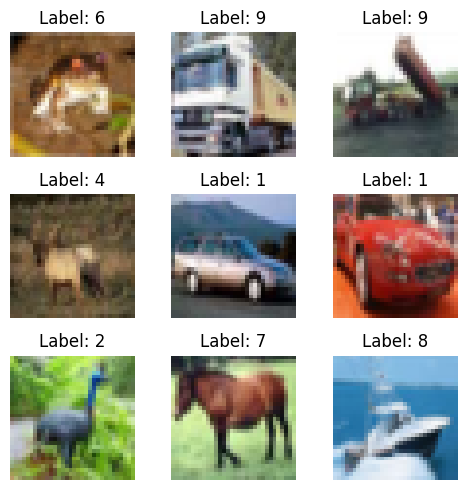

In [16]:
plt.figure(figsize = (5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    
    img = train_df.iloc[i, :-1].values.reshape(32, 32, 3)
    img = np.clip(img, 0, 1) if img.max() <= 1 else img.astype('uint8')
    label = train_df.iloc[i, -1]

    plt.imshow(img)
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

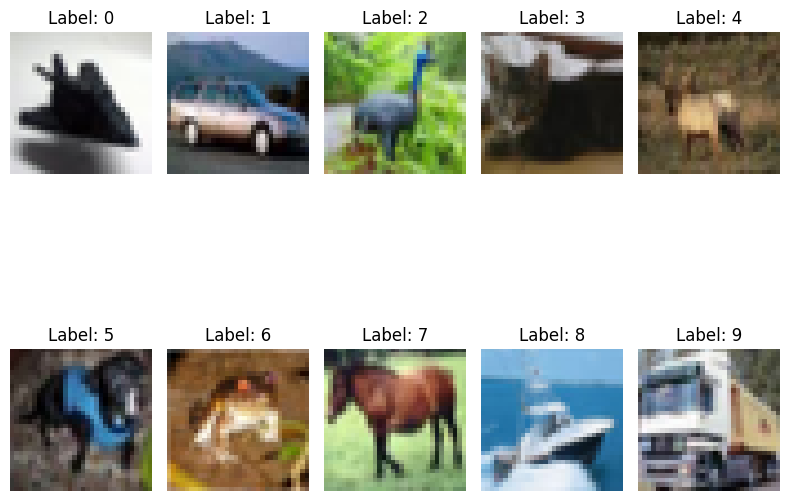

In [22]:
def denormalize(img):
    img = img * 0.5 + 0.5   # đảo ngược (x - 0.5)/0.5
    return img.clamp(0, 1)

def visualize_each_class():
    samples = {}
    for img, label in train_dataset:
        if label not in samples:
            samples[label] = img
        if len(samples) == 10:
            break
    
    fig = plt.figure(figsize = (8, 8))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        img = denormalize(samples[i]).permute(1, 2, 0).numpy() # Convert from (C, H, W) to (H, W, C)
        plt.imshow(img) 
        plt.title(f'Label: {i}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_each_class()


In [25]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### ML Algorithms

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier, StackingClassifier

In [24]:
x_train_df = train_df.drop('label', axis = 1)
y_train_df = train_df['label']
x_test_df = test_df.drop('label', axis = 1)
y_test_df = test_df['label']

### DNN Basic

In [27]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = DNN()

In [28]:
learning_rate = 0.001
num_epochs = 20

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [32]:
print(len(train_dataset))
print(len(train_loader))

50000
782


In [29]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/20], Step [100/782], Loss: 2.3065
Epoch [1/20], Step [200/782], Loss: 2.2956
Epoch [1/20], Step [300/782], Loss: 2.2745
Epoch [1/20], Step [400/782], Loss: 2.2806
Epoch [1/20], Step [500/782], Loss: 2.2792
Epoch [1/20], Step [600/782], Loss: 2.2655
Epoch [1/20], Step [700/782], Loss: 2.2472
Epoch [2/20], Step [100/782], Loss: 2.2645
Epoch [2/20], Step [200/782], Loss: 2.2264
Epoch [2/20], Step [300/782], Loss: 2.2248
Epoch [2/20], Step [400/782], Loss: 2.2247
Epoch [2/20], Step [500/782], Loss: 2.2293
Epoch [2/20], Step [600/782], Loss: 2.1901
Epoch [2/20], Step [700/782], Loss: 2.2083
Epoch [3/20], Step [100/782], Loss: 2.2134
Epoch [3/20], Step [200/782], Loss: 2.1704
Epoch [3/20], Step [300/782], Loss: 2.1865
Epoch [3/20], Step [400/782], Loss: 2.1020
Epoch [3/20], Step [500/782], Loss: 2.1876
Epoch [3/20], Step [600/782], Loss: 2.1815
Epoch [3/20], Step [700/782], Loss: 2.0999
Epoch [4/20], Step [100/782], Loss: 2.1983
Epoch [4/20], Step [200/782], Loss: 2.0817
Epoch [4/20

In [33]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        # images = images.to(device)
        # labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

        for i in range(labels.size(0)):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1
    
    
acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network on the 10000 test images: {acc}')

for i in range(10):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]} : {acc} %')
    
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

# Classification report chi tiết từng lớp
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

Accuracy of the network on the 10000 test images: 40.79
Accuracy of plane : 46.5 %
Accuracy of car : 48.7 %
Accuracy of bird : 22.7 %
Accuracy of cat : 23.0 %
Accuracy of deer : 33.7 %
Accuracy of dog : 36.9 %
Accuracy of frog : 49.2 %
Accuracy of horse : 43.5 %
Accuracy of ship : 57.3 %
Accuracy of truck : 46.4 %
Precision: 0.4024
Recall:    0.4079
F1-score:  0.4023

Classification Report:
              precision    recall  f1-score   support

       plane       0.51      0.47      0.49      1000
         car       0.43      0.49      0.46      1000
        bird       0.31      0.23      0.26      1000
         cat       0.30      0.23      0.26      1000
        deer       0.36      0.34      0.35      1000
         dog       0.39      0.37      0.38      1000
        frog       0.38      0.49      0.43      1000
       horse       0.42      0.43      0.43      1000
        ship       0.47      0.57      0.51      1000
       truck       0.45      0.46      0.46      1000

    accura

### DNN Optimization

In [34]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [35]:
class DNN_Optim(nn.Module):
    def __init__(self):
        super(DNN_Optim, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.drop = nn.Dropout(p = 0.2)
    
    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.drop(x)
        x = torch.relu(self.fc3(x))
        x = self.drop(x)
        x = self.fc4(x)
        return x
    
model = DNN_Optim()

In [36]:
class EarlyStopping:
    def __init__(self, patience=20, delta=0.0):
        self.patience = patience # Dừng nếu không cải thiện sau n epoch
        self.delta = delta       # Ngưỡng cải thiện tối thiểu
        self.best = None         # điểm tốt nhất đã thấy (ở đây là -val_loss)
        self.counter = 0         # đếm số epoch liên tiếp không cải thiện
        self.early_stop = False  
        self.best_state = None   # state_dict tốt nhất để khôi phục

    def __call__(self, val_loss, model):
        score = -val_loss  # minimize loss
        if self.best is None or score > self.best + self.delta:
            self.best = score
            self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()} # copy từng tensor của state_dict sang CPU
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [37]:
num_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-3)
early_stop = EarlyStopping()
lr_schedule = ReduceLROnPlateau(
    optimizer = optimizer,
    mode = 'min',  #Min để theo dõi loss, max để theo dõi accuracy
    factor = 0.5, #Giảm LR còn 50% khi không cải thiện
    patience = 10, #Giảm LR nếu không cải thiện sau 5 epoch
    min_lr = 1e-5 #Giá trị LR tối thiểu
)

In [39]:
val_ratio = 0.2
n_val = int(len(train_dataset) * val_ratio)
n_train = len(train_dataset) - n_val
train_ds, val_ds = random_split(train_dataset, [n_train, n_val])

train_loader= DataLoader(train_ds, batch_size = 64, shuffle = True) #750
val_loader = DataLoader(val_ds,   batch_size=64, shuffle=False)     #188
test_loader= DataLoader(test_dataset, batch_size=64, shuffle=False)

In [40]:
for epoch in range(num_epochs):
    #--- Train ---
    model.train() #Bật dropout
    running_loss = 0.0
    for imgs, labels in train_loader:
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0) # Nhân với batch_size vì Loss của batch là trung bình loss trên 64 mẫu. Cần nhân lại để khôi phục loss thật
    train_loss = running_loss / len(train_loader.dataset)

    #--- Validate ---
    model.eval() #Tắt Dropout. Để kết quả không bị ngẫu nhiên thay đổi mỗi lần chạy
    val_running = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_running += loss.item() * labels.size(0)
    val_loss = val_running / len(val_loader.dataset)
    
    #--- Scheduler & EarlyStopping --- 
    lr_schedule.step(val_loss)
    early_stop(val_loss, model)
    print(f"Epoch {epoch+1:03d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | lr={optimizer.param_groups[0]['lr']:.6f}")

    if early_stop.early_stop: 
        print("Early stopping triggered. Restoring best weights...")
        model.load_state_dict(early_stop.best_state)
        break


Epoch 001 | train_loss=2.3022 | val_loss=2.2972 | lr=0.001000
Epoch 002 | train_loss=2.2948 | val_loss=2.2891 | lr=0.001000
Epoch 003 | train_loss=2.2862 | val_loss=2.2794 | lr=0.001000
Epoch 004 | train_loss=2.2757 | val_loss=2.2668 | lr=0.001000
Epoch 005 | train_loss=2.2622 | val_loss=2.2507 | lr=0.001000
Epoch 006 | train_loss=2.2453 | val_loss=2.2312 | lr=0.001000
Epoch 007 | train_loss=2.2260 | val_loss=2.2094 | lr=0.001000
Epoch 008 | train_loss=2.2049 | val_loss=2.1858 | lr=0.001000
Epoch 009 | train_loss=2.1809 | val_loss=2.1605 | lr=0.001000
Epoch 010 | train_loss=2.1572 | val_loss=2.1347 | lr=0.001000
Epoch 011 | train_loss=2.1326 | val_loss=2.1092 | lr=0.001000
Epoch 012 | train_loss=2.1096 | val_loss=2.0851 | lr=0.001000
Epoch 013 | train_loss=2.0856 | val_loss=2.0618 | lr=0.001000
Epoch 014 | train_loss=2.0657 | val_loss=2.0399 | lr=0.001000
Epoch 015 | train_loss=2.0446 | val_loss=2.0189 | lr=0.001000
Epoch 016 | train_loss=2.0256 | val_loss=1.9993 | lr=0.001000
Epoch 01

In [41]:
model.eval()
n_samples = n_correct = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * n_correct/ n_samples:.2f}%')

Accuracy: 48.92%


### CNN

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    # 255 to 0 -> 1 scale. x_train = (x_train / 255.0).values
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # normalize to mean=0.5, std=0.5 -> range [-1, 1]
])

train_dataset = datasets.CIFAR10(root = '.\data', train = True, download = False, transform = transform)
test_dataset = datasets.CIFAR10(root = '.\data', train = False, download = False, transform = transform)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Admin\AppData\Local\Temp\ipykernel_23180\2814164804.py:8: SyntaxWarning: invalid escape sequence '\d'
  train_dataset = datasets.CIFAR10(root = '.\data', train = True, download = False, transform = transform)
C:\Users\Admin\AppData\Local\Temp\ipykernel_23180\2814164804.py:9: SyntaxWarning: invalid escape sequence '\d'
  test_dataset = datasets.CIFAR10(root = '.\data', train = False, download = False, transform = transform)


In [51]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 'same')
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 'same')
        self.conv3 = nn.Conv2d(64, 64, kernel_size = 3, padding = 'same')
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [44]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 1e-3)

In [45]:
def Training(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        n_samples = n_correct = 0

        for images, labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            #predicted = outputs.argmax(1)  
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset) # hoặc len(train_dataset)
        train_acc = 100.0 * n_correct / n_samples
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        #--- Test ---
        model.eval()
        test_loss = 0.0
        n_samples = n_correct = 0

        with torch.no_grad():
            for images, labels in test_loader: 
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()

        test_loss = test_loss / len(test_loader.dataset)
        test_acc = 100.0 * n_correct / n_samples
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}")
            
    return train_losses, train_accs, test_losses, test_accs
    
(train_losses_cnn, 
 train_accs_cnn,
 test_losses_cnn, 
 test_accs_cnn) = Training(cnn, train_loader, test_loader, criterion, optimizer, num_epochs)


Epoch 1/10: Train Loss: 1.4049, Train Acc: 49.10, Test Loss: 1.1592, Test Acc: 58.02
Epoch 2/10: Train Loss: 0.9956, Train Acc: 64.67, Test Loss: 0.9124, Test Acc: 67.68
Epoch 3/10: Train Loss: 0.8052, Train Acc: 71.44, Test Loss: 0.8576, Test Acc: 70.35
Epoch 4/10: Train Loss: 0.6771, Train Acc: 76.00, Test Loss: 0.7855, Test Acc: 72.97
Epoch 5/10: Train Loss: 0.5687, Train Acc: 79.93, Test Loss: 0.7565, Test Acc: 74.20
Epoch 6/10: Train Loss: 0.4776, Train Acc: 83.03, Test Loss: 0.7628, Test Acc: 74.34
Epoch 7/10: Train Loss: 0.3925, Train Acc: 86.24, Test Loss: 0.8101, Test Acc: 74.15
Epoch 8/10: Train Loss: 0.3197, Train Acc: 88.88, Test Loss: 0.8732, Test Acc: 74.31
Epoch 9/10: Train Loss: 0.2530, Train Acc: 91.08, Test Loss: 0.9611, Test Acc: 73.45
Epoch 10/10: Train Loss: 0.1977, Train Acc: 93.05, Test Loss: 1.0722, Test Acc: 73.77


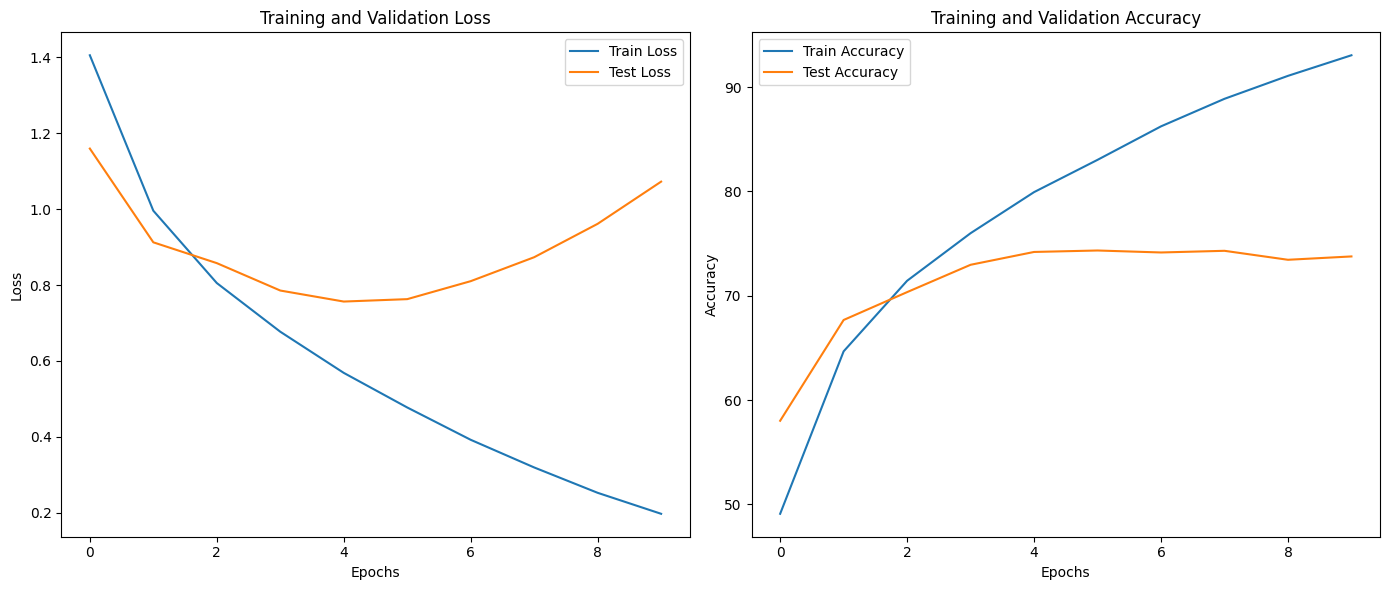

In [46]:
def Line_Graph(train_losses, train_accs, test_losses, test_accs):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

Line_Graph(train_losses_cnn, train_accs_cnn, test_losses_cnn, test_accs_cnn)

              precision    recall  f1-score   support

           0     0.7811    0.7850    0.7830      1000
           1     0.8025    0.8900    0.8440      1000
           2     0.6290    0.6680    0.6479      1000
           3     0.5211    0.5810    0.5494      1000
           4     0.6831    0.6940    0.6885      1000
           5     0.6361    0.6100    0.6228      1000
           6     0.8153    0.7900    0.8024      1000
           7     0.8503    0.7610    0.8032      1000
           8     0.8612    0.8440    0.8525      1000
           9     0.8472    0.7540    0.7979      1000

    accuracy                         0.7377     10000
   macro avg     0.7427    0.7377    0.7392     10000
weighted avg     0.7427    0.7377    0.7392     10000



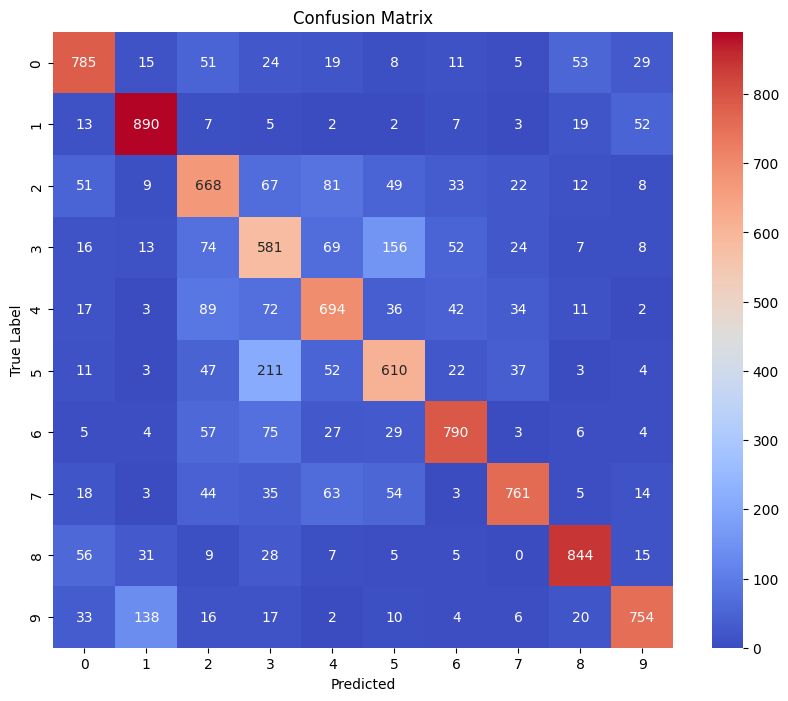

In [48]:
def Evaluate(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    print(classification_report(y_true, y_pred, digits = 4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (10, 8))
    sns.heatmap(cm, 
                annot = True, 
                fmt = 'd',                # Định dạng số trong từng ô
                cmap = 'coolwarm',
                xticklabels = range(10),  #Đặt nhãn cho trục x
                yticklabels = range(10))  #Đặt nhãn cho trục y
    plt.xlabel('Predicted')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

Evaluate(cnn, test_loader)

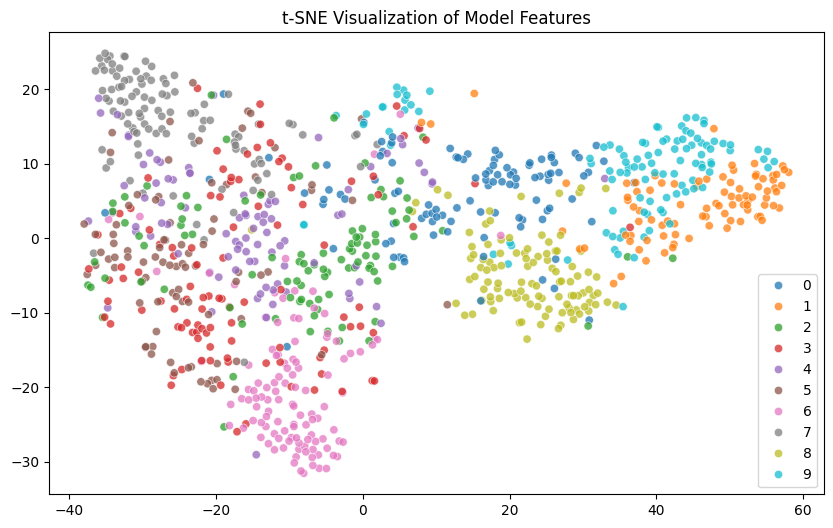

In [49]:
def visualize_tsne(model, data_loader, num_samples=1000):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, label in data_loader:
            output = model(images)
            features.append(output.numpy())
            labels.extend(label.numpy())

            if len(labels) >= num_samples:
                break

    features = np.vstack(features)[:num_samples]   #Ghép tất cả các mảng 2D trong list theo trục dọc
    labels = np.array(labels)[:num_samples]

    tsne = TSNE(n_components=2, 
                perplexity=30,    #effective number of neighbors       
                random_state=42)
    reduced_features = tsne.fit_transform(features)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=labels, palette='tab10', alpha=0.75)
    plt.title('t-SNE Visualization of Model Features')
    plt.show()

visualize_tsne(cnn, test_loader)

### CNN Optimization

In [66]:
class CNN_Optim(nn.Module):
    def __init__(self):
        super(CNN_Optim, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 'same')
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 'same')
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size = 3, padding = 'same')
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout(p = 0.3)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x
    
cnn_optim = CNN_Optim()
print(cnn_optim)

CNN_Optim(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (drop): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [67]:
num_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_optim.parameters(), lr = 1e-3)
lr_schedule = ReduceLROnPlateau(
    optimizer = optimizer, 
    mode = 'min',
    factor = 0.5,
    patience = 10, 
    min_lr = 1e-5
)

In [68]:
val_ratio = 0.2
n_val = int(len(train_dataset) * val_ratio)
n_train = len(train_dataset) - n_val
train_ds, val_ds = random_split(train_dataset, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size = 64, shuffle = True)
val_loader = DataLoader(val_ds, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = True)

In [69]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
    #--- Train ---
    cnn_optim.train() #Bật dropout
    running_loss = 0.0
    n_samples = 0
    n_correct = 0

    for imgs, labels in train_loader:
        outputs = cnn_optim(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0) # Nhân với batch_size vì Loss của batch là trung bình loss trên 64 mẫu. Cần nhân lại để khôi phục loss thật
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100.0 * n_correct / n_samples
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #--- Validate ---
    cnn_optim.eval() #Tắt Dropout. Để kết quả không bị ngẫu nhiên thay đổi mỗi lần chạy
    val_running = 0.0
    n_samples = 0
    n_correct = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            outputs = cnn_optim(imgs)
            loss = criterion(outputs, labels)

            val_running += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

    val_loss = val_running / len(val_loader.dataset)
    val_acc = 100.0 * n_correct / n_samples
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    #--- Scheduler --- 
    lr_schedule.step(val_loss)

    #--- Test ---
    cnn_optim.eval()
    test_running = 0.0
    n_samples = 0 
    n_correct = 0

    with torch.no_grad():
        for imgs, labels in test_loader: 
            outputs = cnn_optim(imgs)
            loss = criterion(outputs, labels)

            test_running += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

    test_loss = test_running / len(test_loader.dataset)
    test_acc = 100.0 * n_correct / n_samples
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    #--- Print ---
    print(f"Epoch {epoch+1}/{num_epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | test_loss = {test_loss:.4f} | lr={optimizer.param_groups[0]['lr']:.6f}")


Epoch 1/100 | train_loss=2.2736 | val_loss=2.2239 | test_loss = 2.2234 | lr=0.001000
Epoch 2/100 | train_loss=2.1479 | val_loss=2.0400 | test_loss = 2.0387 | lr=0.001000
Epoch 3/100 | train_loss=1.9533 | val_loss=1.8349 | test_loss = 1.8307 | lr=0.001000
Epoch 4/100 | train_loss=1.7960 | val_loss=1.6934 | test_loss = 1.6882 | lr=0.001000
Epoch 5/100 | train_loss=1.6859 | val_loss=1.5958 | test_loss = 1.5898 | lr=0.001000
Epoch 6/100 | train_loss=1.6042 | val_loss=1.5204 | test_loss = 1.5158 | lr=0.001000
Epoch 7/100 | train_loss=1.5431 | val_loss=1.4628 | test_loss = 1.4585 | lr=0.001000
Epoch 8/100 | train_loss=1.4895 | val_loss=1.4119 | test_loss = 1.4065 | lr=0.001000
Epoch 9/100 | train_loss=1.4447 | val_loss=1.3688 | test_loss = 1.3657 | lr=0.001000
Epoch 10/100 | train_loss=1.4040 | val_loss=1.3343 | test_loss = 1.3311 | lr=0.001000
Epoch 11/100 | train_loss=1.3635 | val_loss=1.2950 | test_loss = 1.2927 | lr=0.001000
Epoch 12/100 | train_loss=1.3296 | val_loss=1.2604 | test_loss 

In [70]:
n_samples = 0 
n_correct = 0

with torch.no_grad():
    for imgs, labels in test_loader: 
        outputs = cnn_optim(imgs)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

test_acc = 100.0 * n_correct / n_samples
print(test_acc)

75.14


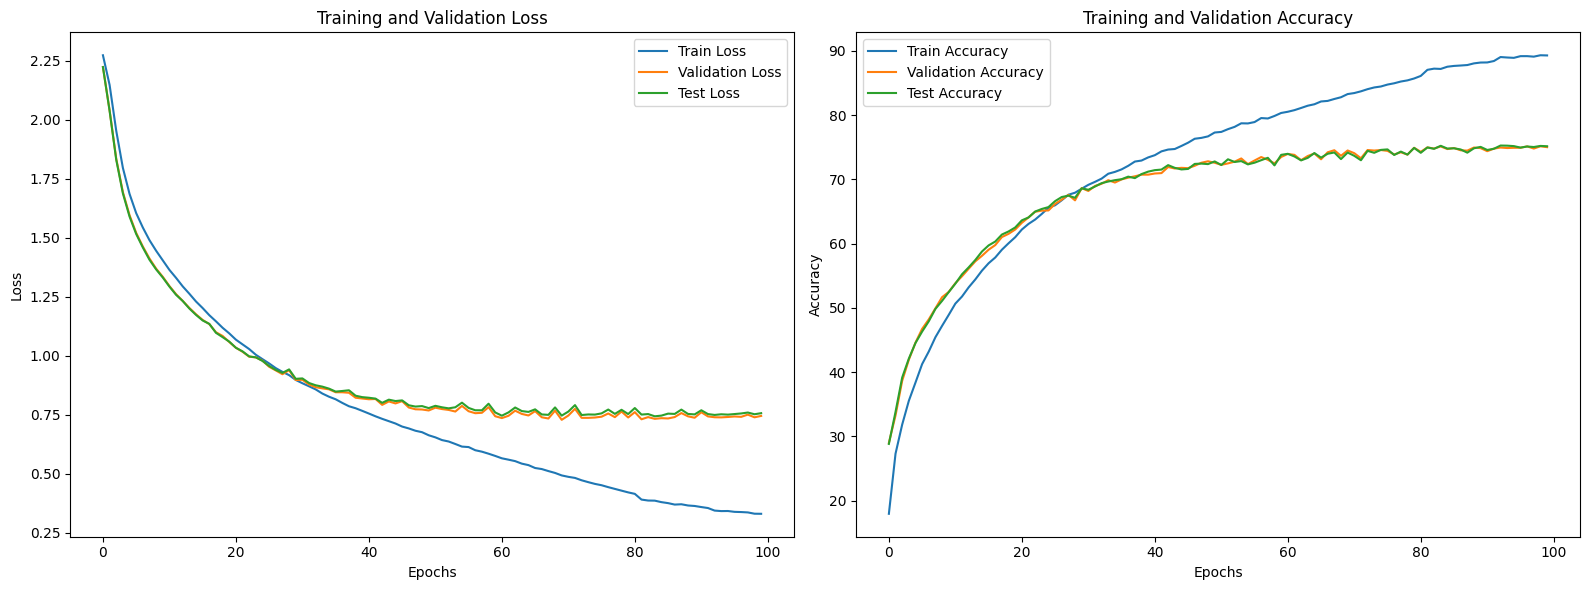

In [72]:
def Line_Graph(train_losses, train_accs, val_losses, val_accs, test_losses, test_accs):
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label = 'Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label = 'Validation Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

Line_Graph(train_losses, train_accs, val_losses, val_accs, test_losses, test_accs)

### ResNet